In [11]:
%load_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
from collections import deque
import os
import matplotlib.pyplot as plt
from dyna import DynaAgent, train, plot_qvalues, test
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the gym environment

In [12]:
env = gym.make('MountainCar-v0')
discr_step = np.array([0.025, 0.005])

## Define the Dyna agents

In [13]:
model_path = 'dyna_model2/'
model_path_large = 'dyna_model_large_bins2/'
model_path_small = 'dyna_model_small_bins2/'
model_path_long_train = 'dyna_model_long_train2/'

dyna = DynaAgent(env, discr_step=discr_step, path=model_path)
dyna_large_bins = DynaAgent(env, discr_step=discr_step * 5, path=model_path_large)
dyna_small_bins = DynaAgent(env, discr_step=discr_step / 2, path=model_path_small)
dyna_long_train = DynaAgent(env, discr_step=discr_step, path=model_path_long_train)

## Train the default Dyna agent

In [14]:
train(env, dyna, n_episodes=3000, log_interval=-1)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [01:43<00:00, 29.03it/s]


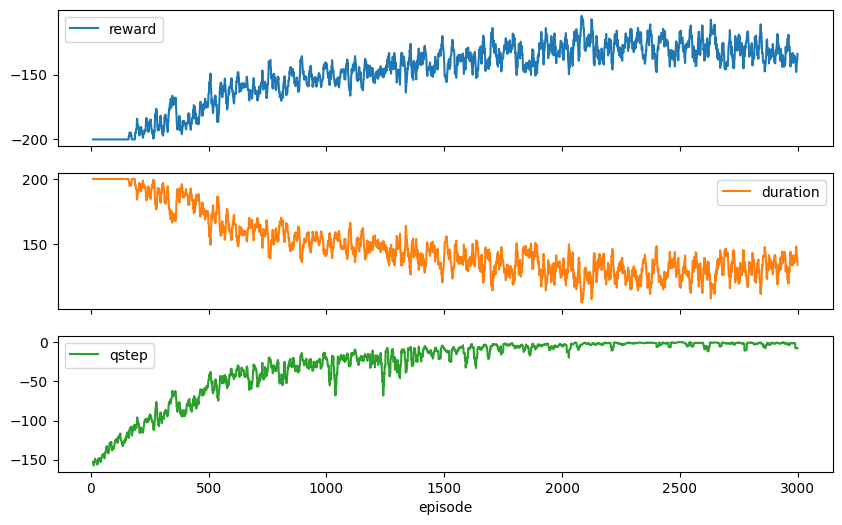

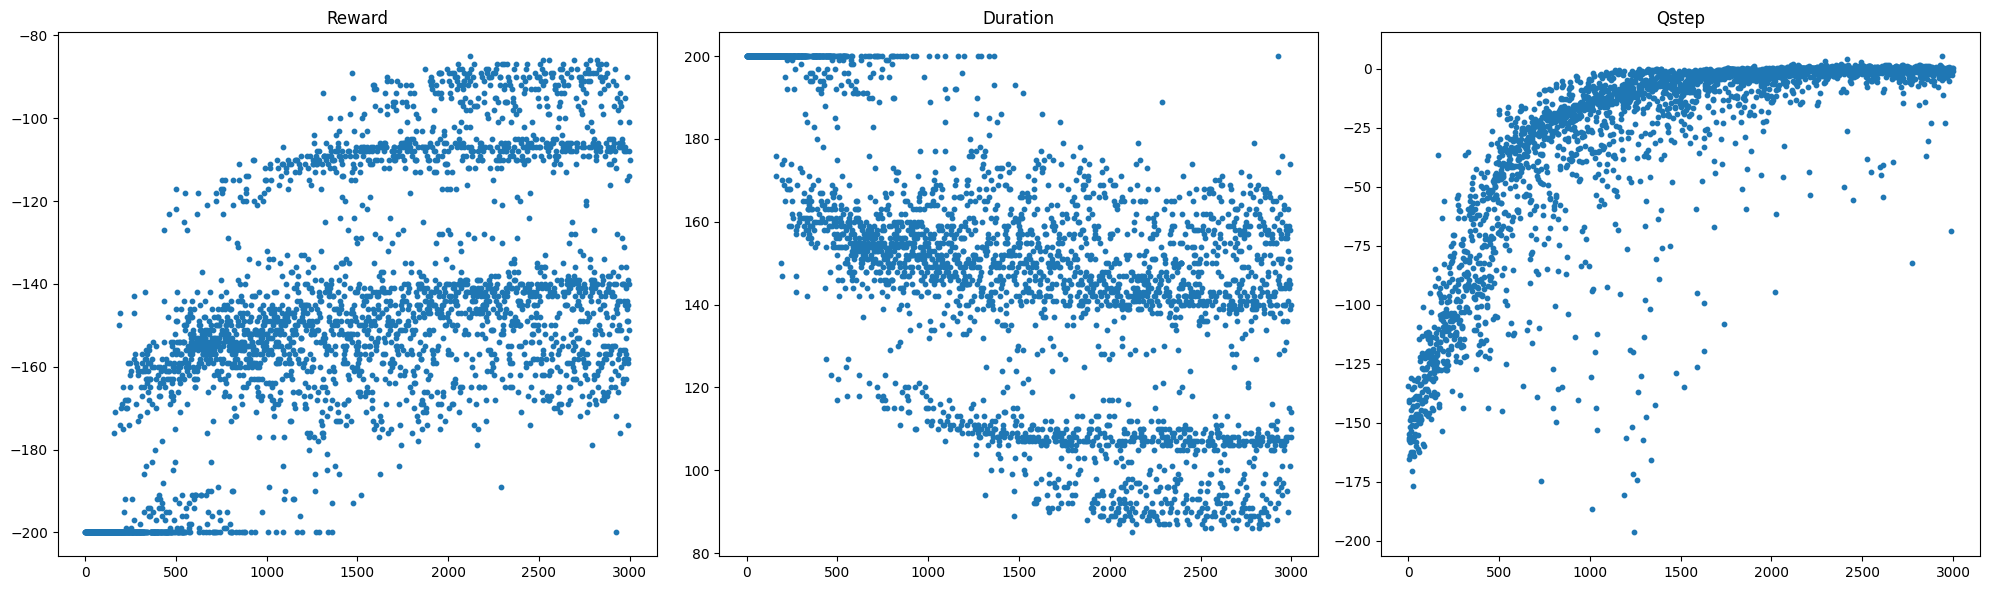

In [7]:
df = pd.read_csv(f'{model_path}episode_results.csv', index_col='episode')
df.rolling(window=10).mean().plot(subplots=True, figsize=(10, 6))
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
s = 10
ax[0].scatter(df.index, df['reward'], label='reward', s=s)
ax[0].set_title('Reward')
ax[1].scatter(df.index, df['duration'], label='duration', s=s)
ax[1].set_title('Duration')
ax[2].scatter(df.index, df['qstep'], label='qstep', s=s)
ax[2].set_title('Qstep')
plt.tight_layout()
plt.show()

## Test the default Dyna agent

In [6]:
agent = DynaAgent(env, discr_step=discr_step, path=model_path, deterministic=True)
agent.load()

rewards = []
duration = 0
done = False
state, _ = env.reset()
while not done:
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state
    rewards.append(reward)
    duration += 1
    
print(f'Total reward: {sum(rewards)}')
print(f'Duration: {duration}')

Total reward: -113.0
Duration: 113


## Does the agent solve the task ?
Yes. We observe the episode duration is smaller than 200 iterations which shoes the agent managed to get the car to the end goal.

## Try to understand why the DynaAgent manages to solve the task even without any auxiliary reward. Explain your reasoning.

The Q-values of our agent are initialized to zero while our environment has negative rewards for all states different from the goal state. Hence, while the agent has never reached the goal, all the state values pairs that have been encountered will have negative a negative Q-value. While the non-encountered state-action pairs will have a Q-value of zero, and thus be more favorable.

Hence, the agent will tend to avoid all the previous state-action pairs and will keep on exploring the environment to find the new unexplored state-action pairs, until it reaches the goal state.

The Dyna agent is model based. It uses a model of the environment to simulate possible future states and rewards. This allows the agent to plan ahead and make informed decisions based on the model's predictions. Hence, the agent will leverage the model to explore different trajectories and outcomes more effectively. Allowing it to rreach unexplored state-action pairs faster than a model-free agent and thus reaching the goal state faster.



## Run Dyna with large bins

In [ ]:
train(env, dyna_large_bins, n_episodes=3000)

## Run Dyna with small bins

In [ ]:
train(env, dyna_small_bins, n_episodes=3000)

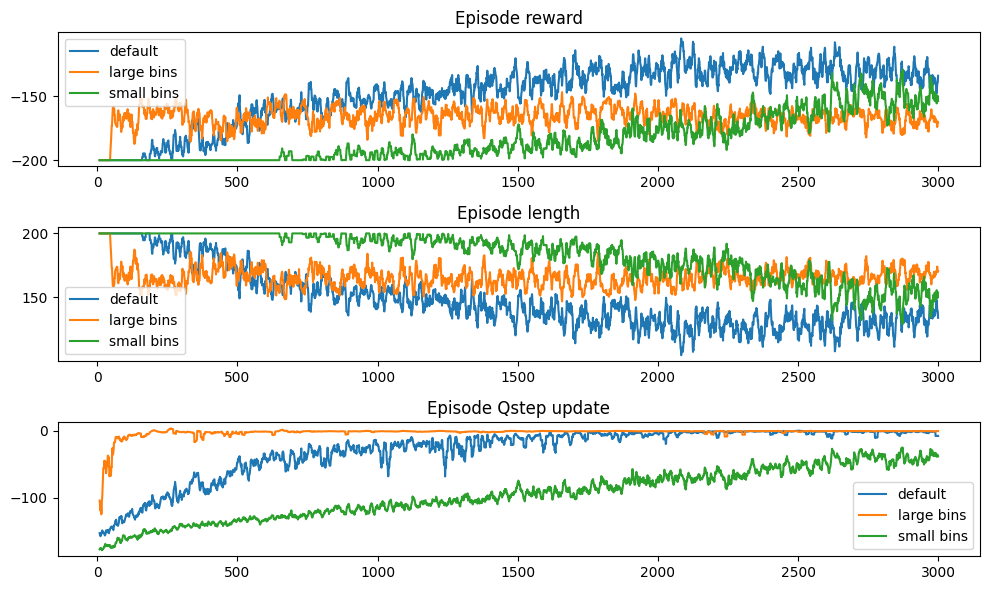

In [8]:
df_default = pd.read_csv(f'{model_path}episode_results.csv', index_col='episode')
df_large = pd.read_csv(f'{model_path_large}episode_results.csv', index_col='episode')
df_small = pd.read_csv(f'{model_path_small}episode_results.csv', index_col='episode')

# Plot the learning curves
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
titles = ['Episode reward', 'Episode length', 'Episode Qstep update']
for i, (cols, ax) in enumerate(zip(df.columns, axes)):
    ax.plot(df_default[cols].rolling(window=10).mean(), label='default')
    ax.plot(df_large[cols].rolling(window=10).mean(), label='large bins')
    ax.plot(df_small[cols].rolling(window=10).mean(), label='small bins')
    ax.set_title(titles[i])
    ax.legend()
plt.tight_layout()
plt.show()

## Changing the size of the discretization step
### Overly large bins
- Loss of Discriminative Power: While the state space might be smaller, each bin represents a larger region of the original continuous space. This can lead to a loss of discriminative power, making it harder for the agent to differentiate between different states within each bin.

- Decreased Learning Efficiency: With fewer distinct states, the agent may struggle to learn an effective policy, especially if important distinctions between states are lost due to coarse discretization. This can result in slower learning and potentially suboptimal policies, hindering the agent's ability to explore the environment efficiently and learn robust policies.

 ### Overly small bins
- Increased Memory and Computation Requirements: With small bins, the state space becomes very large. Storing and processing information about a large number of states requires significant memory and computational resources. This will slow down the learning algortihmn, as it will take much more time for the agent to explore the entire state space in order to yield a performant policy.
It solves it in the first few episodes. Thus the large bin model learns faster then the default one. However, we see that over the learning process,

### These caracteristics can be observed in the learning plot. 
- The small bins model takes around 1600 episode to solve the task for the first time. And we see that the learning still hasn't converged after 3000 episodes as the Q values update step isn't close to zero.
- The large bins model solve the learns much faster them the default. It solves the task in the first few iterations which shoes that the agent explored msot of the state space. The Q values converge fast as well, after 700 episodes the Q values update step is close to zero. However, after 3000 epiosdes, we observe that the large bin model performs less good then the defautl one, showing that the agent has learned a suboptimal policy.

In [5]:
# Test the default agent
dyna = DynaAgent(env, discr_step=discr_step, path=model_path, deterministic=True)
dyna.load()

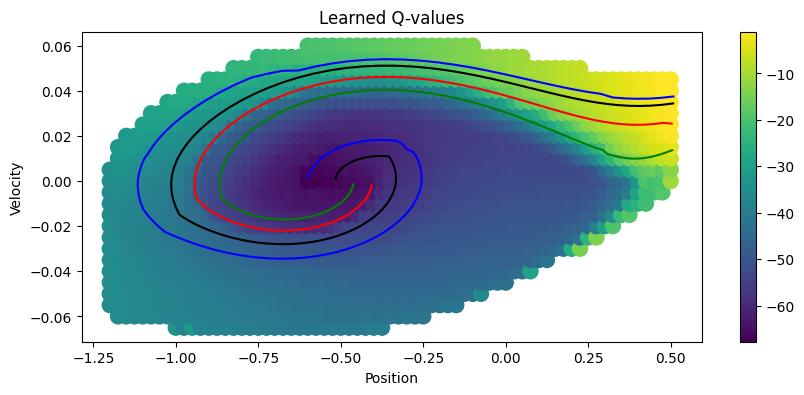

In [12]:
ax = plot_qvalues(model_path, dyna)
test(env, dyna, ax, color='black')
test(env, dyna, ax, color='blue')
test(env, dyna, ax, color='red')
test(env, dyna, ax, color='green')
plt.show()

## What pattern do you see? Comment on the plot.
The leaned Q-values can give us an intuition of the learned policy. The Q-values are higher in the direction of the goal state which shows that the agent has learned a policy that allows it to reach the goal state. 

From the plot, we observe that the agent avoids states with small absolut position and small velocity. While favoring states with high velocity and high position. 

This is consistent with the task at hand which requires the agent to build up enough momentum to reach the goal state.

100%|██████████| 10/10 [00:00<00:00, 20.12it/s]


Episode 9 - Reward: -200.0 - Qvalue step: -165.85337347638622 - Duration: 200


100%|██████████| 100/100 [00:04<00:00, 22.48it/s]


Episode 99 - Reward: -200.0 - Qvalue step: -136.69601025412427 - Duration: 200


100%|██████████| 100/100 [00:04<00:00, 22.79it/s]


Episode 99 - Reward: -200.0 - Qvalue step: -137.71597617463019 - Duration: 200


100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


Episode 99 - Reward: -200.0 - Qvalue step: -131.741668610567 - Duration: 200


100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Episode 99 - Reward: -193.0 - Qvalue step: -57.43967994232859 - Duration: 193


100%|██████████| 100/100 [00:03<00:00, 26.56it/s]


Episode 99 - Reward: -200.0 - Qvalue step: -127.39284433690399 - Duration: 200


100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Episode 99 - Reward: -159.0 - Qvalue step: -35.68645418026706 - Duration: 159


100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Episode 99 - Reward: -200.0 - Qvalue step: -208.0565714885472 - Duration: 200


/tmp/ipykernel_30398/3841840665.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


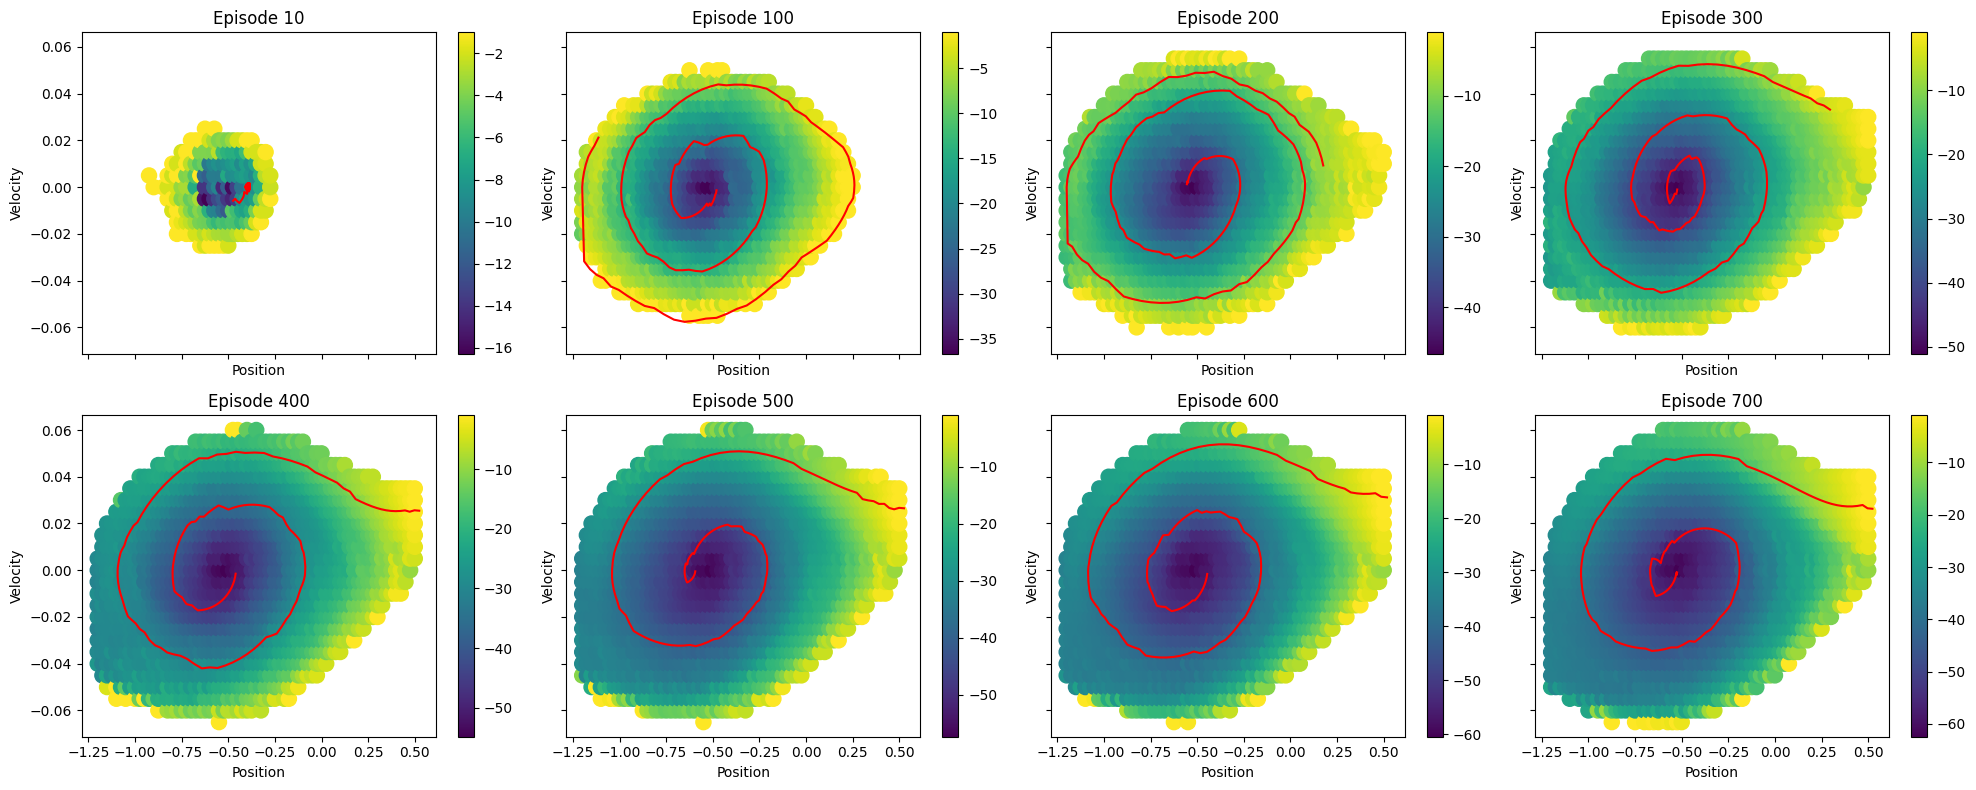

In [4]:
dyna = DynaAgent(env, discr_step=discr_step, path=model_path)
step = 100
plt, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()
train(env, dyna, n_episodes=10, log_interval=10)
ax = plot_qvalues(model_path, dyna, ax=axes[0])
ax.set_title('Episode 10')
test(env, dyna, ax)
for i in range(step, 800, step):
    train(env, dyna, n_episodes=step, log_interval=step)
    ax = plot_qvalues(model_path, dyna, ax=axes[i // step])
    ax.set_title(f'Episode {i}')
    test(env, dyna, ax)

plt.tight_layout()
plt.show()

In [ ]:
# Train default dyna agent for 6000 episodes
train(env, dyna_long_train, n_episodes=6000)

In [ ]:
df_long_train = pd.read_csv(f'{model_path_long_train}episode_results.csv', index_col='episode')

# Use plotly for interactive plots as default pandas backend
import plotly.express as px
pd.options.plotting.backend = "plotly"
df_long_train.rolling(window=1).mean().plot()


pd.options.plotting.backend = "matplotlib"
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
s = 3
ax[0].scatter(df_long_train.index, df_long_train['reward'], label='reward', s=s)
ax[0].set_title('Reward')
ax[1].scatter(df_long_train.index, df_long_train['duration'], label='duration', s=s)
ax[1].set_title('Duration')
ax[2].scatter(df_long_train.index, df_long_train['qstep'], label='qstep', s=s)
ax[2].set_title('Qstep')
plt.tight_layout()
plt.show()

In [15]:
# Test the default dyna model over 1000 epidsodes

agent = DynaAgent(env, discr_step=discr_step, path=model_path, deterministic=True)
agent.load()

reward_hist = []
duration_hist = []
for i in tqdm(range(1000)):
    done = False
    state, _ = env.reset(seed=i)
    episode_duration = 0
    episode_reward = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        episode_reward += reward
        episode_duration += 1
        
    reward_hist.append(episode_reward)
    duration_hist.append(episode_duration)

100%|██████████| 1000/1000 [00:01<00:00, 690.03it/s]


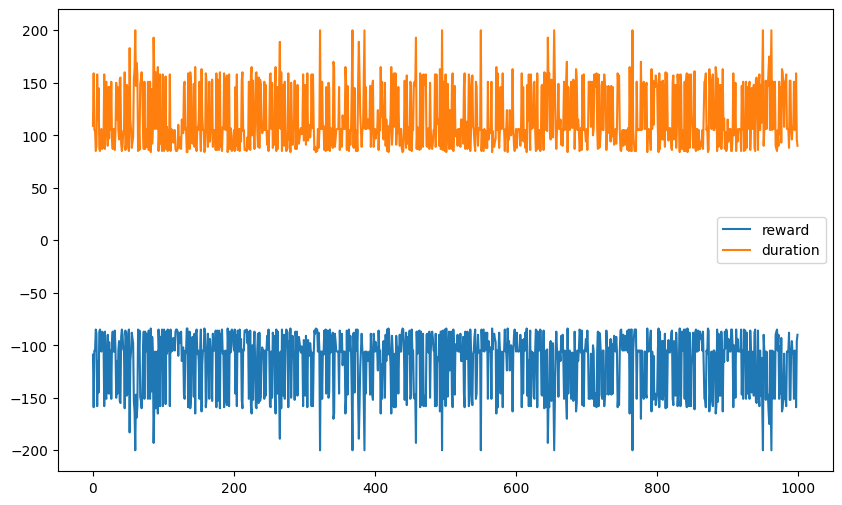

In [16]:
df_test = pd.DataFrame({'reward': reward_hist, 'duration': duration_hist})
df_test.plot(figsize=(10, 6))
df_test.to_csv(f'{model_path}test_results.csv')